In [1]:
!pip install tensorflow==2.9.0 tensorflow-probability==0.16.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from google.colab import drive
from sklearn.preprocessing import KBinsDiscretizer


In [2]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/data.csv'
# Load the dataset

data = pd.read_csv(file_path)
data=data[['TRANS DATE','MERCHANT NAME', 'CARD NUMBER', 'ORIGINAL GROSS AMT']]
#data= data[data['ORIGINAL GROSS AMT'] < 500]
data= data[data['ORIGINAL GROSS AMT'] > 0]

# Drop rows with any remaining missing values
data['TRANS DATE']=pd.to_datetime(data['TRANS DATE'], errors='coerce')
data_cleaned = data.dropna()

# Convert 'TRANS DATE' to datetime format and handle missing values in 'MERCHANT NAME'
data['TRANS DATE'] = pd.to_datetime(data['TRANS DATE'], errors='coerce')
data= data.loc[data['TRANS DATE']>'01-01-2020']
data['MERCHANT NAME'] = data['MERCHANT NAME'].fillna('Unknown')

Q1 = data['ORIGINAL GROSS AMT'].quantile(0.25)
Q3 = data['ORIGINAL GROSS AMT'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data= data[(data['ORIGINAL GROSS AMT'] >= lower_bound) & (data['ORIGINAL GROSS AMT'] <= upper_bound)]


from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
data['ORIGINAL GROSS AMT BIN'] = kb.fit_transform(data[['ORIGINAL GROSS AMT']])
data['P ORIGINAL GROSS AMT BIN'] = data.groupby('CARD NUMBER')['ORIGINAL GROSS AMT BIN'].shift(1)


data['P ORIGINAL GROSS AMT'] = data.groupby('CARD NUMBER')['ORIGINAL GROSS AMT'].shift(1)
data['P TRANS DATE'] = data.groupby('CARD NUMBER')['TRANS DATE'].shift(1)
# Drop rows with any remaining missing values
data_cleaned = data.dropna().copy()

# Feature Engineering: Create time-related features
data_cleaned['P_YEAR'] = data_cleaned['P TRANS DATE'].dt.year
data_cleaned['P_MONTH'] = data_cleaned['P TRANS DATE'].dt.month
data_cleaned['P_DAY'] = data_cleaned['P TRANS DATE'].dt.day
data_cleaned['P_DAY_OF_WEEK'] = data_cleaned['P TRANS DATE'].dt.dayofweek
data_cleaned = data_cleaned.dropna()#.copy()

merchant_counts = data['MERCHANT NAME'].value_counts()
rare_merchants = merchant_counts[merchant_counts < 10].index
data['MERCHANT NAME'] = data['MERCHANT NAME'].replace(rare_merchants, 'Other')


# Encode the categorical variable MERCHANT NAME
le_merchant = LabelEncoder()
data_cleaned['MERCHANT NAME'] = le_merchant.fit_transform(data_cleaned['MERCHANT NAME'])
data_cleaned['P MERCHANT NAME'] = data_cleaned.groupby('CARD NUMBER')['MERCHANT NAME'].shift(1)
data_cleaned = data_cleaned.dropna()

# Splitting data into features and target variables
unique_card_numbers = data_cleaned['CARD NUMBER'].unique()
train_list = []
test_list = []

for card_number, group in data_cleaned.groupby('CARD NUMBER'):
    # Determine the number of rows that will go into the test set (last 20%)
    n_test = int(len(group) * 0.2)

    # Split the group into train and test
    train_list.append(group.iloc[:-n_test])  # All except the last 20%
    test_list.append(group.iloc[-n_test:])   # Last 20%

# Concatenate all the train and test groups into two DataFrames
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

train_list = []
test_list = []

for card_number, group in data_cleaned.groupby('CARD NUMBER'):
    # Determine the number of rows that will go into the test set (last 20%)
    n_test = int(len(group) * 0.2)

    # Ensure at least one sample is included in the test set if there are enough rows
    if n_test == 0 and len(group) > 1:
        n_test = 1

    # Split the group into train and test
    if n_test > 0:
        train_list.append(group.iloc[:-n_test])  # All except the last 20%
        test_list.append(group.iloc[-n_test:])   # Last 20%
    else:
        train_list.append(group)  # If n_test is 0, put all data in the training set

# Concatenate all the train and test groups into two DataFrames
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Reset index if needed
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

X_mer_train=train_df.drop(columns=['TRANS DATE','MERCHANT NAME','P TRANS DATE','ORIGINAL GROSS AMT','ORIGINAL GROSS AMT BIN'])#
X_mer_test=test_df.drop(columns=['TRANS DATE','MERCHANT NAME','P TRANS DATE','ORIGINAL GROSS AMT','ORIGINAL GROSS AMT BIN'])
y_mer_test=test_df['MERCHANT NAME'].values
y_mer_train=train_df['MERCHANT NAME'].values

print(X_mer_train.shape)
print(X_mer_test.shape)
print(y_mer_test.shape)
print(y_mer_train.shape)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


(30367, 8)
(7562, 8)
(7562,)
(30367,)


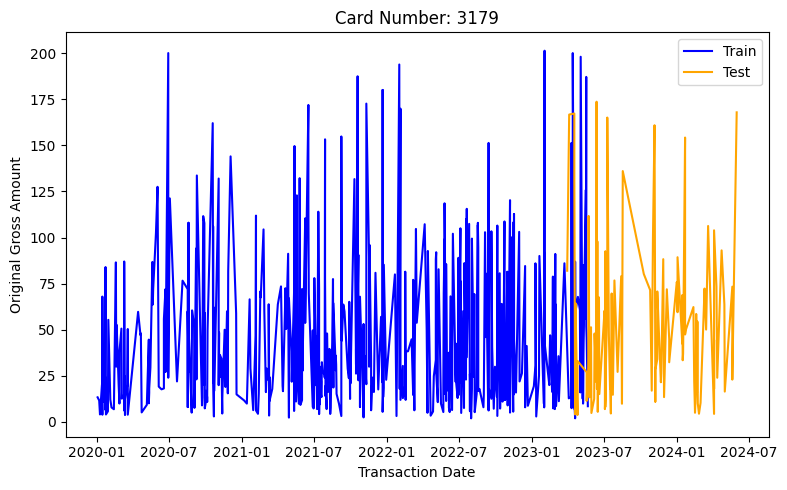

In [ ]:
import matplotlib.pyplot as plt

# Select three card numbers for visualization
selected_card_numbers = unique_card_numbers[:3]

# Create a figure for test train division
fig, axes = plt.subplots(figsize=(8, 5))

# Get data for the specific card number
card_train_data = train_df[train_df['CARD NUMBER'] == 3195]
card_test_data = test_df[test_df['CARD NUMBER'] == card_number]

# Plot training data
plt.plot(card_train_data['TRANS DATE'], card_train_data['ORIGINAL GROSS AMT'], color='blue', label='Train') # Use plt.plot


# Plot testing data
plt.plot(card_test_data['TRANS DATE'], card_test_data['ORIGINAL GROSS AMT'], color='orange', label='Test') # Use plt.plot


# Set title and labels
plt.title(f'Card Number: {card_number}') # Use plt.title
plt.xlabel('Transaction Date') # Use plt.xlabel
plt.ylabel('Original Gross Amount') # Use plt.ylabel
plt.legend() # Use plt.legend

plt.tight_layout()
plt.show()
#plt.figure.savefig("test_train_plot.pdf") # Use plt.figure

In [ ]:
file_path = '/content/drive/My Drive/le_merchant.pkl'
import pickle
# Save the fitted LabelEncoder using pickle
with open(file_path, 'wb') as file:
    pickle.dump(le_merchant, file)

In [ ]:
file_path = '/content/drive/My Drive/kbins_discretizer.pkl'

# Save the fitted KBinsDiscretizer
joblib.dump(kb, file_path)

['/content/drive/My Drive/kbins_discretizer.pkl']

Categorical Naive Bayes

In [ ]:

X_mer_train=train_df.drop(columns=['TRANS DATE','MERCHANT NAME','P TRANS DATE','ORIGINAL GROSS AMT','ORIGINAL GROSS AMT BIN','P ORIGINAL GROSS AMT', "P_DAY_OF_WEEK"])#
X_mer_test=test_df.drop(columns=['TRANS DATE','MERCHANT NAME','P TRANS DATE','ORIGINAL GROSS AMT','ORIGINAL GROSS AMT BIN','P ORIGINAL GROSS AMT', "P_DAY_OF_WEEK"])


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score


# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # Smoothing parameter
}

# Initialize the CategoricalNB model
model = CategoricalNB()

# Set up the GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_mer_train, y_mer_train)


# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.2f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

# Predict on the test set
y_merchant_pred =  best_model.predict(X_mer_test)
y_merchant_pred_train = best_model.predict(X_mer_train)

test_accuracy = accuracy_score(y_mer_test, y_merchant_pred)

print(f"Test set accuracy with best model: {test_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Best hyperparameters: {'alpha': 0.1}
Best cross-validation accuracy: nan
Test set accuracy with best model: 0.49


In [ ]:
import joblib
model_path = '/content/drive/My Drive/best_model.pkl'

# Save the best model to the specified path
joblib.dump(best_model, model_path)

['/content/drive/My Drive/best_model.pkl']

Errors

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
y_merchant_pred_train = best_model.predict(X_mer_train)
# Evaluate the model for merchant name prediction
accuracy_merchant = accuracy_score(y_mer_test, y_merchant_pred)
accuracy_merchant_train = accuracy_score(y_mer_train, y_merchant_pred_train)

# Calculate precision, F1 score, and confusion matrix
precision_merchant = precision_score(y_mer_test, y_merchant_pred, average='weighted', zero_division=1)
precision_merchant_train = precision_score(y_mer_train, y_merchant_pred_train, average='weighted', zero_division=1)
f1_merchant = f1_score(y_mer_test, y_merchant_pred, average='weighted')
f1_merchant_train = f1_score(y_mer_train, y_merchant_pred_train, average='weighted')


# Print the evaluation metrics
print(f'Merchant Name Prediction - Accuracy (Test): {accuracy_merchant}')
print(f'Merchant Name Prediction - Accuracy (Train): {accuracy_merchant_train}')
print(f'Merchant Name Prediction - Precision (Test): {precision_merchant}')
print(f'Merchant Name Prediction - F1 Score (Test): {f1_merchant}')
print(f'Merchant Name Prediction - Precision (Train): {precision_merchant_train}')
print(f'Merchant Name Prediction - F1 Score (Train): {f1_merchant_train}')


Merchant Name Prediction - Accuracy (Test): 0.48968526844750065
Merchant Name Prediction - Accuracy (Train): 0.567754470313169
Merchant Name Prediction - Precision (Test): 0.6173692494257053
Merchant Name Prediction - F1 Score (Test): 0.41065946681735294
Merchant Name Prediction - Precision (Train): 0.6657053235228947
Merchant Name Prediction - F1 Score (Train): 0.4900780413353902


Guassian Naive Bayes

In [3]:

X_mer_train=train_df.drop(columns=['TRANS DATE','MERCHANT NAME','P TRANS DATE','ORIGINAL GROSS AMT','ORIGINAL GROSS AMT BIN','P ORIGINAL GROSS AMT BIN'])#
X_mer_test=test_df.drop(columns=['TRANS DATE','MERCHANT NAME','P TRANS DATE','ORIGINAL GROSS AMT','ORIGINAL GROSS AMT BIN','P ORIGINAL GROSS AMT BIN'])


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize the selected columns
columns_to_normalize = ['P_DAY', 'P_YEAR','P_MONTH','P_DAY_OF_WEEK','P ORIGINAL GROSS AMT']#,'ORIGINAL GROSS AMT'

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
X_mer_train[columns_to_normalize] = scaler.fit_transform(X_mer_train[columns_to_normalize])
X_mer_test[columns_to_normalize] = scaler.transform(X_mer_test[columns_to_normalize])

# Define the model
model_merchant = GaussianNB()

# Define the hyperparameters to tune
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Set up GridSearchCV or RandomizedSearchCV
# Using GridSearchCV
grid_search = GridSearchCV(estimator=model_merchant, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# For faster tuning, use RandomizedSearchCV instead of GridSearchCV
# random_search = RandomizedSearchCV(estimator=model_merchant, param_distributions=param_grid, n_iter=30, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model with hyperparameter tuning
grid_search.fit(X_mer_train, y_mer_train)

# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_

# Predict on the test set with the best model
y_merchant_pred = best_model.predict(X_mer_test)
y_merchant_pred_train = best_model.predict(X_mer_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Errors

In [ ]:
# Evaluate the model for merchant name prediction
accuracy_merchant = accuracy_score(y_mer_test, y_merchant_pred)
accuracy_merchant_train = accuracy_score(y_mer_train, y_merchant_pred_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Merchant Name Prediction - Accuracy: {accuracy_merchant}')
print(f'Merchant Name Prediction - Accuracy Train: {accuracy_merchant_train}')
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Evaluate the model for merchant name prediction
accuracy_merchant = accuracy_score(y_mer_test, y_merchant_pred)
accuracy_merchant_train = accuracy_score(y_mer_train, y_merchant_pred_train)

# Calculate recall, precision, F1 score, and confusion matrix
precision_merchant = precision_score(y_mer_test, y_merchant_pred, average='weighted', zero_division=1)
precision_merchant_train = precision_score(y_mer_train, y_merchant_pred_train, average='weighted', zero_division=1)
f1_merchant = f1_score(y_mer_test, y_merchant_pred, average='weighted')
f1_merchant_train = f1_score(y_mer_train, y_merchant_pred_train, average='weighted')


# Print the evaluation metrics
print(f'Merchant Name Prediction - Accuracy (Test): {accuracy_merchant}')
print(f'Merchant Name Prediction - Accuracy (Train): {accuracy_merchant_train}')
print(f'Merchant Name Prediction - Precision (Test): {precision_merchant}')
print(f'Merchant Name Prediction - F1 Score (Test): {f1_merchant}')
print(f'Merchant Name Prediction - Precision (Train): {precision_merchant_train}')
print(f'Merchant Name Prediction - F1 Score (Train): {f1_merchant_train}')

Best Parameters: {'var_smoothing': 0.002848035868435802}
Merchant Name Prediction - Accuracy: 0.42263951335625494
Merchant Name Prediction - Accuracy Train: 0.4142325550762341
Merchant Name Prediction - Accuracy (Test): 0.42263951335625494
Merchant Name Prediction - Accuracy (Train): 0.4142325550762341
Merchant Name Prediction - Precision (Test): 0.6849571820224394
Merchant Name Prediction - F1 Score (Test): 0.29171574486184343
Merchant Name Prediction - Precision (Train): 0.6896504146404078
Merchant Name Prediction - F1 Score (Train): 0.2675173387286375


Bayesain nueral network

In [4]:
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import numpy as np
num_classes = len(np.unique(data_cleaned['MERCHANT NAME']))
num_classes = np.int32(np.max(data_cleaned['MERCHANT NAME']) + 1)
#y_date_train_encoded = label_encoder.fit_transform(y_date_train)
# Alias for convenience
tfpl = tfp.layers

# Ensure X_mer_train_scaled is a TensorFlow tensor
X_mer_train_scaled = tf.convert_to_tensor(X_mer_train, dtype=tf.float32)

# Define the model architecture
input_shape = (X_mer_train_scaled.shape[1],)
inputs = Input(shape=input_shape)

# Define Bayesian layers directly
#x = tfpl.DenseFlipout(128, activation='relu',)(inputs)
#x = Dropout(0.3)(x)
x = tfpl.DenseFlipout(64, activation='relu',)(inputs)#(x)
x = Dropout(0.5)(x)
x = tfpl.DenseFlipout(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = tfpl.DenseFlipout(num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])#tfpl.negative_log_likelihood()sparse_categorical_crossentropy
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)
# Train the model
history = model.fit(
    X_mer_train_scaled,  # Training features
    y_mer_train,  # Training labels
    epochs=50,            # Number of epochs
    validation_split=0.2,  # Split 20% of the training data as validation data
    batch_size=32,        # Batch size for training
    verbose=1,            # Display progress during training
    callbacks=[early_stopping])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/50
760/760 [==============================] - 21s 23ms/step - loss: 130181.0078 - accuracy: 0.2089 - val_loss: 108515.6797 - val_accuracy: 0.1791
Epoch 2/50
760/760 [==============================] - 13s 17ms/step - loss: 88137.7031 - accuracy: 0.3203 - val_loss: 68468.8906 - val_accuracy: 0.1791
Epoch 3/50
760/760 [==============================] - 14s 18ms/step - loss: 51256.8672 - accuracy: 0.3302 - val_loss: 35465.5312 - val_accuracy: 0.1793
Epoch 4/50
760/760 [==============================] - 19s 25ms/step - loss: 23531.4668 - accuracy: 0.3377 - val_loss: 13585.4893 - val_accuracy: 0.1793
Epoch 5/50
760/760 [==============================] - 13s 17ms/step - loss: 7822.3286 - accuracy: 0.3395 - val_loss: 3701.9077 - val_accuracy: 0.1793
Epoch 6/50
760/760 [==============================] - 13s 17ms/step - loss: 2152.5808 - accuracy: 0.3401 - val_loss: 1228.2506 - val_accuracy: 0.1793
Epoch 7/50
760/760 [==============================] - 14s 18ms/step - loss: 1051.8661 - ac

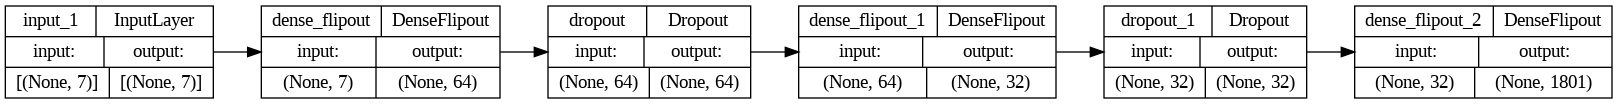

In [5]:
from tensorflow.keras.utils import plot_model

# Plot the model structure and save it to a file
plot_model(model, to_file='mer_bnn_hori.png', show_shapes=True, show_layer_names=True, rankdir='LR')


Errors

In [ ]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
X_mer_test_scaled = tf.convert_to_tensor(X_mer_test, dtype=tf.float32)

y_merchant_pred_train=model.predict(X_mer_train_scaled)

y_merchant_pred=model.predict(X_mer_test_scaled)
y_merchant_pred=np.argmax(y_merchant_pred,axis=1)
y_merchant_pred_train=np.argmax(y_merchant_pred_train,axis=1)
accuracy_merchant = accuracy_score(y_mer_test, y_merchant_pred)
accuracy_merchant_train = accuracy_score(y_mer_train, y_merchant_pred_train)

# Calculate recall, precision, F1 score
recall_merchant = recall_score(y_mer_test, y_merchant_pred, average='weighted')
recall_merchant_train = recall_score(y_mer_train, y_merchant_pred_train, average='weighted')
precision_merchant = precision_score(y_mer_test, y_merchant_pred, average='weighted', zero_division=1)
precision_merchant_train = precision_score(y_mer_train, y_merchant_pred_train, average='weighted', zero_division=1)
f1_merchant = f1_score(y_mer_test, y_merchant_pred, average='weighted')
f1_merchant_train = f1_score(y_mer_train, y_merchant_pred_train, average='weighted')


# Print the evaluation metrics
print(f'Merchant Name Prediction - Accuracy (Test): {accuracy_merchant}')
print(f'Merchant Name Prediction - Accuracy (Train): {accuracy_merchant_train}')
print(f'Merchant Name Prediction - Recall (Test): {recall_merchant}')
print(f'Merchant Name Prediction - Precision (Test): {precision_merchant}')
print(f'Merchant Name Prediction - F1 Score (Test): {f1_merchant}')
print(f'Merchant Name Prediction - Recall (Train): {recall_merchant_train}')
print(f'Merchant Name Prediction - Precision (Train): {precision_merchant_train}')
print(f'Merchant Name Prediction - F1 Score (Train): {f1_merchant_train}')


237/237 [==============================] - 2s 10ms/step
Merchant Name Prediction - Accuracy (Test): 0.3378735784184078
Merchant Name Prediction - Accuracy (Train): 0.3105673922349919
Merchant Name Prediction - Recall (Test): 0.3378735784184078
Merchant Name Prediction - Precision (Test): 0.7762849765748522
Merchant Name Prediction - F1 Score (Test): 0.17065671500623347
Merchant Name Prediction - Recall (Train): 0.3105673922349919
Merchant Name Prediction - Precision (Train): 0.7858847128846513
Merchant Name Prediction - F1 Score (Train): 0.14719137022806217
